<a href="https://colab.research.google.com/github/Eliokay/Climate-Project/blob/main/Education_inequality_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project addresses inequality of educational opportunity in U.S. high schools. I will focus on average student performance on the ACT or SAT exams that students take as part of the college application process. I expect a range of school performance on these exams, but I want to know if school performance is predicted by socioeconomic factors.

## Import libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Load clean data

In [49]:
train = pd.read_csv("https://raw.githubusercontent.com/Eliokay/Education-Inequality/main/training_df%20(1).csv")
test = pd.read_csv("https://raw.githubusercontent.com/Eliokay/Education-Inequality/main/testing_df%20(1).csv")

##### $\rightarrow$ Review the contents of the data set.

In [85]:
train.head()

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,school_type,school_level,average_act
0,0.466597,-1.127324,0.209793,-0.863339,0.227066,TN,Regular,High,19.200000
1,0.409184,-1.269705,-0.358443,-0.470183,-0.035991,PA,Regular,High,19.493284
2,-0.559425,1.491710,0.366137,-0.026901,1.064549,LA,Regular,High,19.700000
3,5.888706,-1.074722,-3.070968,-1.583402,2.313099,IL,Regular,High,17.700000
4,0.306803,-0.323910,-1.430660,-0.532627,1.991674,TX,Regular,High,21.398046


In [84]:
test.head()

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,school_type,school_level,average_act
0,-0.736988,-1.296808,-0.453704,0.048760,1.365214,LA,Regular School,High,17.800000
1,-0.513971,1.160424,0.805299,0.095940,-1.438810,WI,Regular School,High,25.100000
2,-0.835100,0.412381,0.056771,-0.356222,-0.753352,OH,Regular School,High,23.000000
3,1.216329,-1.337695,-0.015270,-1.040890,0.403663,TN,Regular School,High,18.900000
4,-0.639003,-0.321943,0.715821,-0.293165,-0.396080,IN,Regular School,High,21.229548


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, I have broken it down to specific questions about the data.



1. How does Average ACT scores vary by state
2. How well can we predict students' ACT scores based on socioeconomic factors?
3. After controlling for mean income, do other socioeconomic factors still significantly affect ACT scores?
4. What factor contributes the most to ACT scores

## Analysis

###Descriptive Statistics

In [52]:
train.describe()

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,average_act
count,5781.000000,5781.000000,5781.000000,5781.000000,5.781000e+03,5781.000000
mean,0.000432,-0.000410,-0.001073,-0.000714,-3.343152e-16,20.287339
std,0.999498,0.999479,0.999675,0.999657,1.000000e+00,2.509341
min,-1.709864,-2.906787,-3.343281,-2.065465,-1.979013e+00,12.362637
25%,-0.688084,-0.721987,-0.563175,-0.638158,-7.492114e-01,18.800000
50%,-0.217190,-0.085904,0.162189,-0.218773,-1.583851e-01,20.500000
75%,0.439610,0.654006,0.731550,0.379923,6.211665e-01,22.000000
max,6.569992,2.574636,1.880186,7.098765,2.508618e+00,30.946276


This shows us that the mean average ACT score is 20.29, the lowest is 12.36 and the hughest is 30.94

###Exploring ACT score by state

In [53]:
average_act_scores_by_state = train.groupby('state')['average_act'].mean().sort_values(ascending=False)
top_three_states = average_act_scores_by_state.head(3)
bottom_three_states = average_act_scores_by_state.tail(3)


median_income_by_state = train.groupby('state')['median_income'].median()
merged_data1 = pd.merge(top_three_states, median_income_by_state, on='state')
merged_data2 = pd.merge(bottom_three_states, median_income_by_state, on='state')

print("Top three states with the highest ACT scores and their median income:")
print(merged_data1)

print("\nBottom three states with the lowest ACT scores and their median income:")
print(merged_data2)


Top three states with the highest ACT scores and their median income:
       average_act  median_income
state                            
WI       22.009091      -0.126008
MA       21.746868       0.831553
WA       21.395333       0.002725

Bottom three states with the lowest ACT scores and their median income:
       average_act  median_income
state                            
LA       18.948428      -0.547890
NY       17.650441      -0.234813
DE       17.547823       0.184715


This tells us that the Average ACT scores isn't neccessarily influenced just by median income as would be expected- The state with the highest ACT score, Wisconson, doesn't have the highest median Income. Hence, it is important to explore what other factors could be contributing to these variations in the academic performances.

###Building a regression model to predict ACT scores

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
from re import X
features = ["rate_unemployment", "percent_college", "percent_married", "median_income",
            "percent_lunch", "state", "zip_code", "school_type", "school_level"]

target = ["average_act"]
num_vars = ["rate_unemployment", "percent_college", "percent_married", "median_income", "percent_lunch"]

X_train = train[num_vars]
y_train = train[target]

X_test = test[num_vars]
y_test = test[target]

##Linear Regression

###Model Training

In [56]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.intercept_, model.coef_)

[20.28750821] [[-0.13631959  0.29341074 -0.00251598 -0.0094701  -1.77020139]]


In [86]:
# Print the coefficient and feature names
for feature, coef in zip(num_vars, model.coef_[0]):
    print(f"{feature}: {coef}")


rate_unemployment: -0.13631958864381963
percent_college: 0.2934107391418965
percent_married: -0.0025159810030754848
median_income: -0.009470096647835935
percent_lunch: -1.7702013905151628


###Model Evaluation

In [57]:
#training the model
lr_y_pred_train = model.predict(X_train)
lr_y_pred_train

array([[19.49882909],
       [19.92824952],
       [18.91631931],
       ...,
       [15.64421088],
       [21.87720798],
       [20.51710748]])

In [58]:
one = np.linspace(y_train.min(), y_train.max(), 100)
rmse = np.sqrt(np.mean((lr_y_pred_train - y_train)**2))

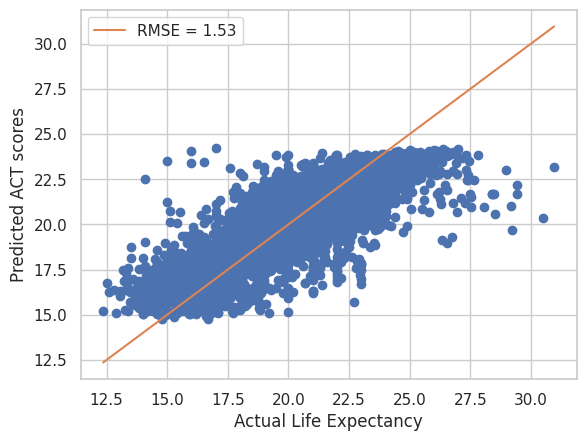

In [60]:
fig, ax = plt.subplots()
ax.plot(y_train, lr_y_pred_train, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
ax.set_ylabel("Predicted ACT scores")
ax.set_xlabel("Actual Life Expectancy")
ax.legend()

In [61]:
from sklearn.metrics import r2_score
r2_score(y_train, lr_y_pred_train)

0.6273693675054406

###lr Model with test data

In [62]:
lr_y_pred_test = model.predict(X_test)
lr_y_pred_test

array([[17.59145266],
       [23.24210221],
       [21.85916128],
       ...,
       [22.7474688 ],
       [22.72951711],
       [20.5777765 ]])

In [63]:
one = np.linspace(y_test.min(), y_test.max(), 100)
rmse = np.sqrt(np.mean((lr_y_pred_test - y_test)**2))

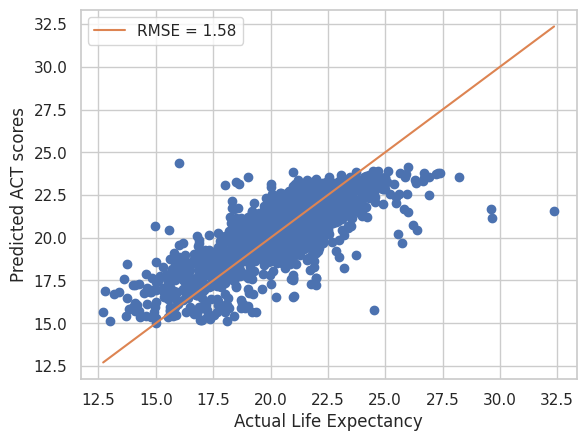

In [64]:
fig, ax = plt.subplots()
ax.plot(y_test, lr_y_pred_test, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
ax.set_ylabel("Predicted ACT scores")
ax.set_xlabel("Actual Life Expectancy")
ax.legend()


In [65]:
r2_score(y_test, lr_y_pred_test)

0.604268311008194

After training on the train data, the model does well to predict base on the test data as the RSME difference is just a .05 difference. However, this value of 1.58 is still a bit too high. Can another type of model make more accurate predictions?

##Standard Regression Tree

Let's explore this using a standard regression tree

In [66]:
from sklearn.tree import DecisionTreeRegressor

###Model Training

In [67]:
tree_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=5).fit(X_train, y_train)
tree_reg.feature_importances_

array([0.03657204, 0.08331938, 0.03844132, 0.03245882, 0.80920844])

###Model Evaluation

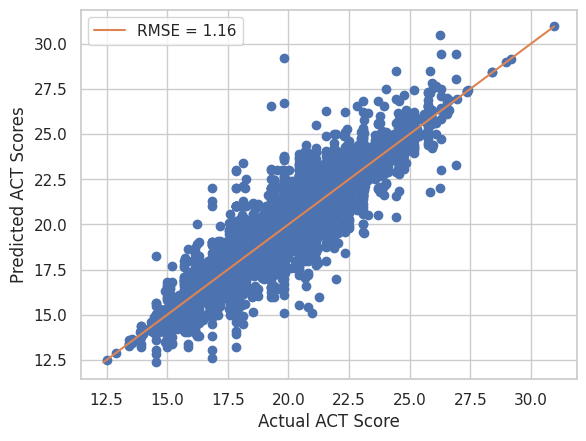

In [68]:
tr_y_pred_train = tree_reg.predict(X_train).squeeze()
one = np.linspace(y_train.min(), y_train.max(), 100)
rmse = np.sqrt(np.mean((tr_y_pred_train - y_train.squeeze())**2))


fig, ax = plt.subplots()
ax.plot(tr_y_pred_train, y_train, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
ax.set_ylabel("Predicted ACT Scores")
ax.set_xlabel("Actual ACT Score")
ax.legend()

This is a better model with a lower RMSE value.

In [69]:
from sklearn.metrics import r2_score
r2_score(y_train, tr_y_pred_train)

0.7858799125377505

This model is able to predict about 79% of the ACT score's variability.

###DT Model Evaluation with Test Data

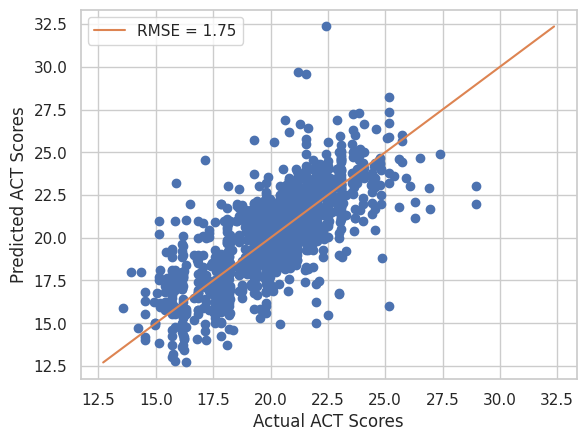

In [70]:
tr_y_pred_test = tree_reg.predict(X_test).squeeze()
one = np.linspace(y_test.min(), y_test.max(), 100)
rmse = np.sqrt(np.mean((tr_y_pred_test - y_test.squeeze())**2))


fig, ax = plt.subplots()
ax.plot(tr_y_pred_test, y_test, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
ax.set_ylabel("Predicted ACT Scores")
ax.set_xlabel("Actual ACT Scores")
ax.legend()

In [71]:
r2_score(y_test, tr_y_pred_test)


0.5116181974517977

This model is able to predict about 51% of the ACT score's variability. This is a poorer prediction

Although the standard decision tree is a better model for making predictions using the training data compared to the linear regression model, it is a lot worse for the testing data. This could be due to overfitting

# What Factors have the most impact on the predictive power of the model?

### Regression Model without Mean Income

In [74]:
target = ["average_act"]
num_vars_add1 = ["rate_unemployment", "percent_college", "percent_married", "percent_lunch"]

X_train_add1 = train[num_vars_add1]
y_train = train[target]

X_test = test[num_vars]
y_test = test[target]

In [75]:
model_add1 = LinearRegression()
model_add1.fit(X_train_add1, y_train)
print(model_add1.intercept_, model_add1.coef_)


[20.28750941] [[-0.13593691  0.28866813 -0.00573956 -1.76944526]]


In [76]:
lr_y_pred_train1 = model_add1.predict(X_train_add1)
lr_y_pred_train1

array([[19.4956748 ],
       [19.93110459],
       [18.90840173],
       ...,
       [15.65218892],
       [21.87349456],
       [20.51693397]])

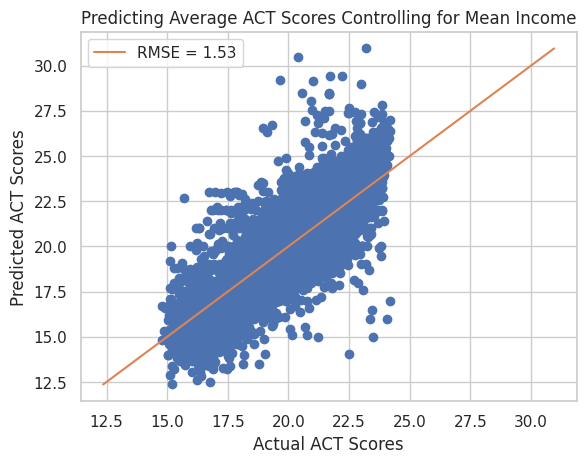

In [77]:
lr_y_pred_train1 = model_add1.predict(X_train_add1).squeeze()
one = np.linspace(y_train.min(), y_train.max(), 100)
rmse = np.sqrt(np.mean((lr_y_pred_train1 - y_train.squeeze())**2))


fig, ax = plt.subplots()
ax.plot(lr_y_pred_train1, y_train, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
plt.title('Predicting Average ACT Scores Controlling for Mean Income')
ax.set_ylabel("Predicted ACT Scores")
ax.set_xlabel("Actual ACT Scores")
ax.legend()

In [78]:
r2_score(y_train, lr_y_pred_train1)

0.6273640231977466

Regression modell without Percent Lunch

In [79]:
target = ["average_act"]
num_vars_add2 = ["rate_unemployment", "percent_college", "median_income", "percent_married"]

X_train_add2 = train[num_vars_add2]
y_train = train[target]

X_test_add2 = test[num_vars]
y_test = test[target]

In [80]:
model_add2 = LinearRegression()
model_add2.fit(X_train_add2, y_train)
print(model_add2.intercept_, model_add2.coef_)

[20.28840239] [[-0.51817414  0.59783344  0.22912045  0.40224461]]


In [81]:
lr_y_pred_train2 = model_add2.predict(X_train_add2)
lr_y_pred_train2

array([[19.25925173],
       [19.06539108],
       [21.61118921],
       ...,
       [18.45613499],
       [21.20198028],
       [19.59161919]])

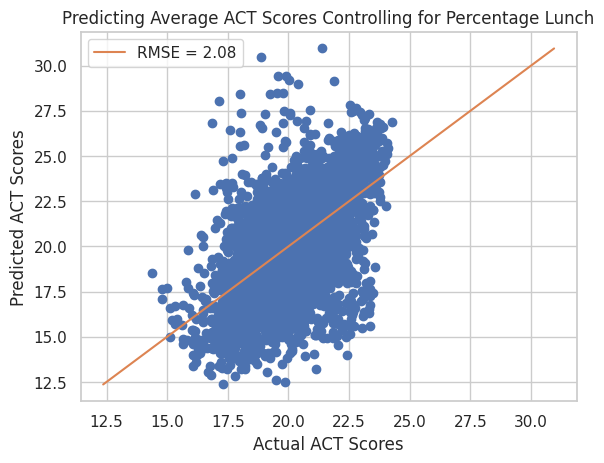

In [82]:
lr_y_pred_train2 = model_add2.predict(X_train_add2).squeeze()
one = np.linspace(y_train.min(), y_train.max(), 100)
rmse = np.sqrt(np.mean((lr_y_pred_train2 - y_train.squeeze())**2))


fig, ax = plt.subplots()
ax.plot(lr_y_pred_train2, y_train, 'o')
ax.plot(one, one, '-', label = f"RMSE = {rmse:.2f}")
plt.title('Predicting Average ACT Scores Controlling for Percentage Lunch')
ax.set_ylabel("Predicted ACT Scores")
ax.set_xlabel("Actual ACT Scores")
ax.legend()

In [83]:
r2_score(y_train, lr_y_pred_train2)

0.31214795371534065

This tells us that the socioeconomic factor with the most impact in predicting the ACT scores is the Percent_lunch(percent of students at the school who receive free or reduced price lunch).


# Additional Analysis

### What Information can we gather from the categorical Data that wasn't used in the regressions?

<ipython-input-87-4ef476638bba>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='school_type', y='average_act', data=train, ci=None)


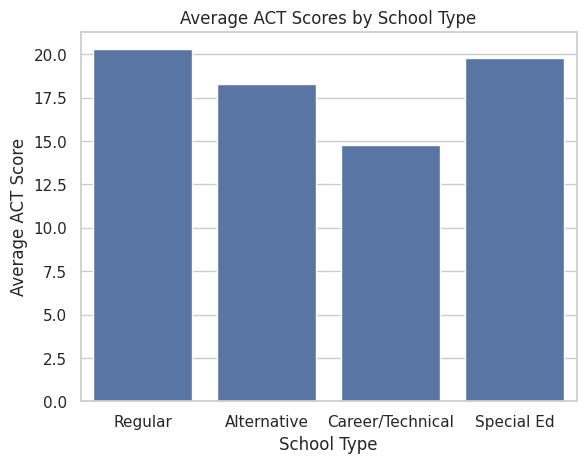

In [87]:
#this aids in visibility, to make the labels shorter
train.loc[train['school_type'] == 'Regular School', 'school_type'] = 'Regular'
train.loc[train['school_type'] == 'Alternative School', 'school_type'] = 'Alternative'
train.loc[train['school_type'] == 'Career and Technical School', 'school_type'] = 'Career/Technical'
train.loc[train['school_type'] == 'Special Education School', 'school_type'] = 'Special Ed'


sns.barplot(x='school_type', y='average_act', data=train, ci=None)
plt.title('Average ACT Scores by School Type')
plt.xlabel('School Type')
plt.ylabel('Average ACT Score')

plt.show()

This reveals that Kids in special Ed did just as good as those in regular schools.

## Conclusion

There are lots of take aways from this analysis:

- The Average ACT scores isn't neccessarily influenced just by median income as would be expected.

- The linear regression model was better at predicting the ACT scores compared to the Standard Decision tree in this case.

- The most important predictor of ACT scores in this dataset was the percent of students at the school who receive free or reduced price lunch

- The type of school students attended could be an indicator of academic performance. Those who went to regular schools performed the best but those that received special education perfumed almost as good. Those that attended career or technical schools performed the poorest.